In [47]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import uproot3 as uproot
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import sys
from scipy.optimize import curve_fit
from scipy.integrate import quad

import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline


def hist1d(df,nbins,weights=None,**kwargs):
    if weights is None:
        out=np.histogram(df,bins=nbins)
    else:
        out=np.histogram(df,bins=nbins,weights=weights)
    hep.histplot(out,**kwargs)
    return out
    
def hist2d(dfx,dfy,nbins,weights=None,**kwargs):
    if weights is None:
        out=np.histogram2d(dfx,dfy,bins=nbins)
    else:
        out=np.histogram2d(dfx,dfy,bins=nbins,weights=weights)
    hep.hist2dplot(out,**kwargs)
    return out

In [33]:
ofolder="/d/grid17/ln16/dselector_v3/study_lmac/results/"
os.system("mkdir -p "+ofolder)

0

In [4]:
cols=[
    "mismatchPairMass_13","mismatchPairMass_24","mismatchPairMass_23","mismatchPairMass_14",
    "Mpi0eta","weightASBS","weightBS","cosTheta_eta_gj","Mpi0","Meta","AccWeight","chiSq","Ebeam","mandelstam_t","mandelstam_tp","Mpi0p","Metap","omegaCut",
     "mandelstam_teta","mandelstam_tpi0","run","event","rfTime","phi_eta_lab","phi_pi0_lab","BeamAngle"
]

#floc="/d/grid17/ln16/myDSelector/zDSelectedBkgndSamples_noOmegaCut/omega_pi0g/degALL_bkgndSample_mEllipse_8288_tLT1_treeFlat_DSelector.root"
floc="/d/grid17/ln16/dselector_v3/study_lmac/omega_pi0g/"
treeName="tree_4g_flat"
tree=uproot.open(floc)[treeName]
df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)

In [19]:
cols=[
    "mismatchPairMass_13","mismatchPairMass_24","mismatchPairMass_23","mismatchPairMass_14",
    "Mpi0eta","weightASBS","weightBS","cosTheta_eta_gj","Mpi0","Meta","AccWeight","chiSq","Ebeam","mandelstam_t","mandelstam_tp","Mpi0p","Metap","omegaCut",
     "mandelstam_teta","mandelstam_tpi0","phi_eta_lab","phi_pi0_lab","BeamAngle"
]

# floc="/d/grid17/ln16/myDSelector/zDSelectedBkgndSamples_noOmegaCut/flat_etapi_2018_8/degALL_bkgndSample_mEllipse_8288_tLT1_treeFlat_DSelector.root"
floc="/d/grid17/ln16/dselector_v3/study_lmac/flat_2017_1/bkgndSample_recon_acc_flat.root"
treeName="kin"
tree=uproot.open(floc)[treeName]
df_sig=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
# df_sig=df_sig.sample(len(df))

In [20]:
df_datas=[]
for run in ["2017_1","2018_1","2018_8"]:
    floc="/d/grid17/ln16/dselector_v3/study_lmac/gluex_"+run+"/bkgndSample_recon_acc_flat.root"
    treeName="kin"
    tree=uproot.open(floc)[treeName]
    df_data=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    df_datas.append(df_data)
df_data=pd.concat(df_datas)

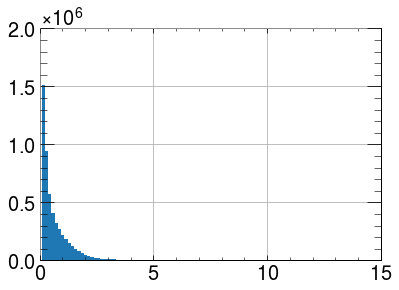

In [55]:
df_data.mandelstam_t.hist(bins=100)

(-2000.0, 25000.0)

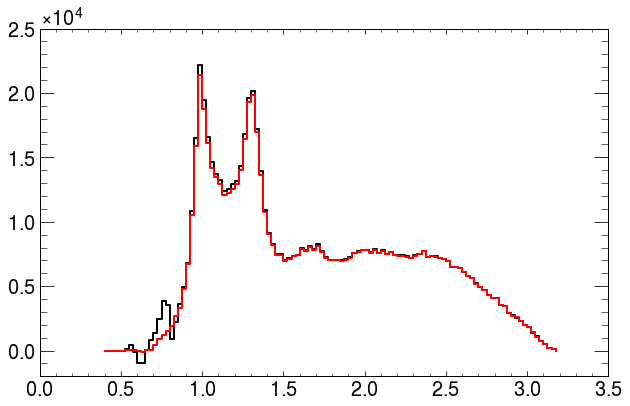

In [72]:
plt.figure(figsize=(10,6))

edges=np.arange(0.4,3.2,step=0.025)
hep.histplot(np.histogram(df_data.Mpi0eta,weights=df_data.weightASBS,bins=edges),c='black')
tmp=applyCondition(df_data)
hep.histplot(np.histogram(tmp.Mpi0eta,weights=tmp.weightASBS,bins=edges),c='red')
plt.ylim(-2000)

In [21]:
df["noWeight"]=1
df_sig["noWeight"]=1
df_data["noWeight"]=1

Text(0, 0.5, 'Entries / 0.007 GeV')

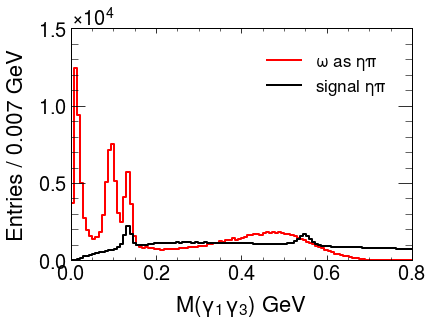

In [24]:
# 1D distributions 13,14,23,24 all look the same
edges=hist1d(df["mismatchPairMass_13"],200,color='red',label=r"$\omega$ as $\eta\pi$")[1]
norm=[len(df)/len(df_sig)]*len(df_sig)
hist1d(df_sig["mismatchPairMass_13"],edges,weights=norm,color='black',label=r"signal $\eta\pi$")
plt.legend()
plt.xlim(0,0.8)
plt.xlabel(r"$M(\gamma_1\gamma_3)$ GeV")
plt.ylabel(f"Entries / {edges[1]-edges[0]:0.3f} GeV")

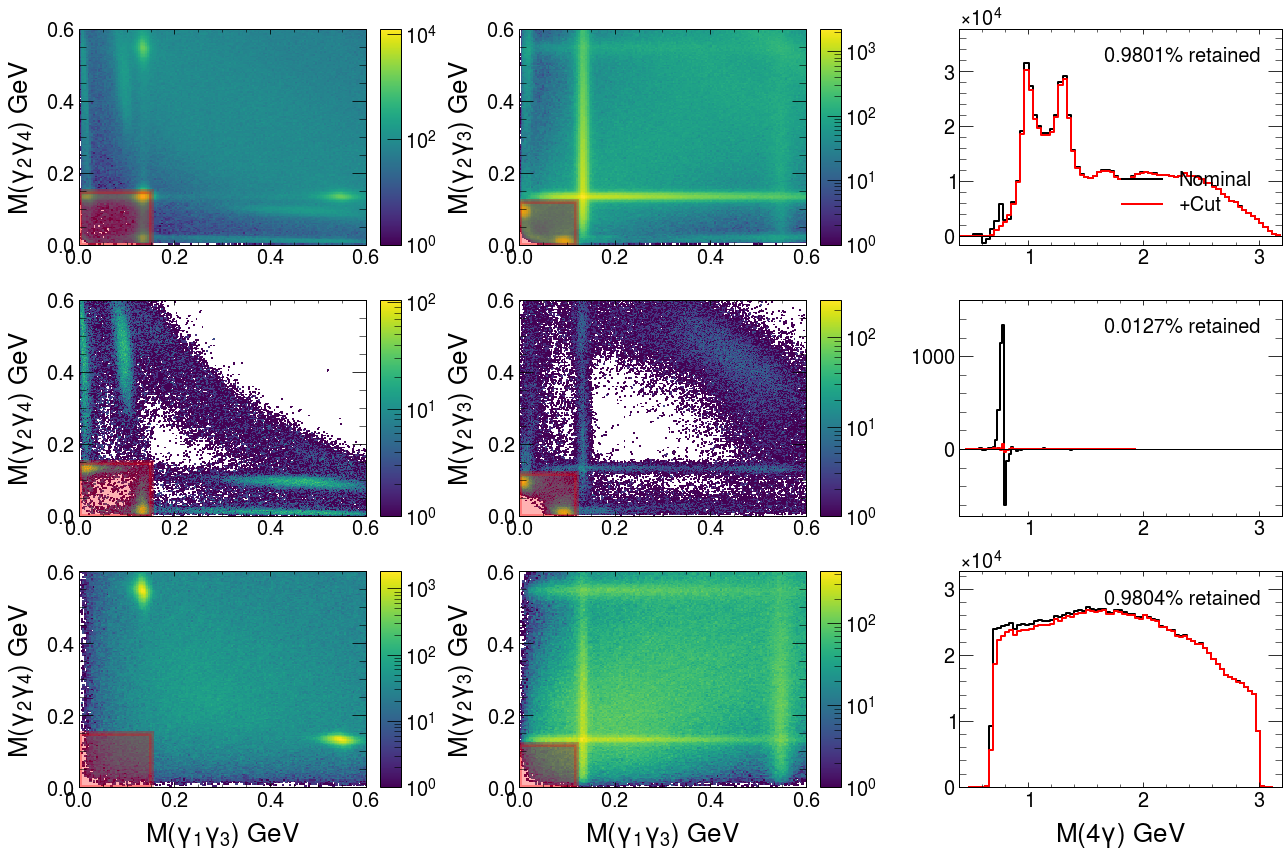

In [46]:
# 13vs24 looks exactly like 23vs14
##################################
fig,axes=plt.subplots(3,3,figsize=(18,12))#,sharex=True,sharey=True)
axes=axes.flatten()

#l,u=0.115,0.145
l,u=0.12,0.15
def applyCondition(d):
    condition=\
        ((d["mismatchPairMass_13"]<u)&(d["mismatchPairMass_24"]<u))|\
        ((d["mismatchPairMass_14"]<u)&(d["mismatchPairMass_23"]<u))|\
        ((d["mismatchPairMass_13"]<l)&(d["mismatchPairMass_23"]<l))|\
        ((d["mismatchPairMass_14"]<l)&(d[":qmismatchPairMass_24"]<l))
#     condition=\
#         ((df["mismatchPairMass_13"]<u)&(df["mismatchPairMass_13"]>l))|\
#         ((df["mismatchPairMass_23"]<u)&(df["mismatchPairMass_23"]>l))|\
#         ((df["mismatchPairMass_14"]<u)&(df["mismatchPairMass_14"]>l))|\
#         ((df["mismatchPairMass_24"]<u)&(df["mismatchPairMass_24"]>l))
#         ((df["Mpi0"]<u)&(df["Mpi0"]>l))|\
#         ((df["Meta"]<u)&(df["Meta"]>l))
    
    # Above are cuts we want a selection
    condition=~condition
    return d[condition]

tmp=applyCondition(df)
tmp_sig=applyCondition(df_sig)
tmp_data=applyCondition(df_data)

from matplotlib.patches import Rectangle
for i,t,d in zip(range(3),[tmp_data,tmp,tmp_sig],[df_data,df,df_sig]):
    hist2d(d["mismatchPairMass_13"],d["mismatchPairMass_24"],(800,800),ax=axes[3*i],norm=mpl.colors.LogNorm())
    axes[3*i].set_xlim(0,0.6)
    axes[3*i].set_ylim(0,0.6)
    axes[3*i].set_ylabel(r"$M(\gamma_2\gamma_4)$ GeV",size=26)
    axes[3*i].add_patch(Rectangle((0,0), u, u,alpha=0.3,color='red',linewidth=5))

    hist2d(d["mismatchPairMass_13"],d["mismatchPairMass_23"],(800,800),ax=axes[3*i+1],norm=mpl.colors.LogNorm())
    axes[3*i+1].set_xlim(0,0.6)
    axes[3*i+1].set_ylim(0,0.6)
    axes[3*i+1].set_ylabel(r"$M(\gamma_2\gamma_3)$ GeV",size=26)
    axes[3*i+1].add_patch(Rectangle((0,0), l, l,alpha=0.3,color='red',linewidth=5))

    counts,edges=hist1d(d["Mpi0eta"],75,d["weightASBS"],ax=axes[3*i+2],color='black',label="Nominal")
    hist1d(t["Mpi0eta"],edges,t["weightASBS"],ax=axes[3*i+2],color='red',label="+Cut")
    axes[3*i+2].axhline(0,linewidth=1,c='black')
    if i==0:
        axes[3*i+2].legend(loc=4,prop={"size":20})
#     axes[3*i+2].set_xlim(-1,1)
    axes[3*i+2].set_xlim(0.4,3.2)
    mini=counts.min()
    mini=mini*1.2 if mini<0 else mini*0.8
    axes[3*i+2].set_ylim(mini,counts.max()*1.2)
    axes[3*i+2].text(0.45,0.85,f"{t['weightASBS'].sum()/d['weightASBS'].sum():0.4f}% retained",size=20,transform=axes[3*i+2].transAxes)

                     
axes[6].set_xlabel(r"$M(\gamma_1\gamma_3)$ GeV",size=26)
axes[7].set_xlabel(r"$M(\gamma_1\gamma_3)$ GeV",size=26)
axes[8].set_xlabel(r"$M(4\gamma)$ GeV",size=26)
plt.tight_layout()
plt.savefig(ofolder+"lowMassAltComboSelect.png")